In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import boxcox1p
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import roc_curve, roc_auc_score,classification_report
from sklearn.utils import resample

from time import time

In [2]:
file='C:/Users/fsatter1/Documents/biV/loan2m.csv'
data=pd.read_csv(file,low_memory=False)
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print(data.shape)
data.info()

(2260668, 145)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [4]:
#See all the columns description
pd.set_option('display.max_colwidth', -1)
datades=pd.read_excel('C:/Users/fsatter1/Documents/biV/LCDataDictionary.xlsx')
#datades

In [61]:
#Keeping possible features
mydata=data[['loan_amnt','term','int_rate','grade','emp_length','home_ownership','annual_inc',
             'verification_status','loan_status','purpose','dti','delinq_2yrs',''
             'open_acc','pub_rec', 'revol_bal', 'revol_util','total_acc','out_prncp','recoveries',
             'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'tot_coll_amt',
             'tot_cur_bal','open_acc_6m','open_il_24m','mths_since_rcnt_il','total_bal_il', 'il_util',
             'open_rv_12m','all_util','inq_fi','total_cu_tl','inq_last_12m','acc_open_past_24mths',
             'bc_util','chargeoff_within_12_mths','delinq_amnt','mort_acc','mths_since_recent_inq',
             'num_actv_bc_tl','num_bc_tl','pub_rec_bankruptcies','tax_liens',
             'total_bc_limit','disbursement_method']]          
#sorted(list(mydata.columns))
mydata.shape

(2260668, 46)

**EDA**

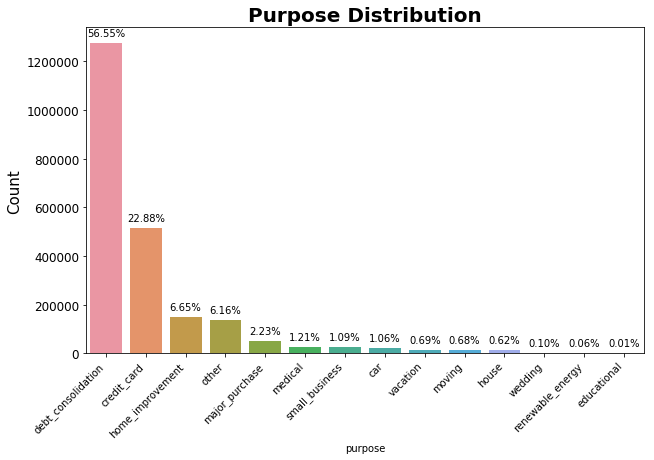

In [18]:
#Explore Purpose
plt.figure(figsize = (10,6))
graph=sns.countplot(x='purpose', data=mydata,order = mydata['purpose'].value_counts().index)
plt.xticks(rotation = 45, horizontalalignment='right')
plt.yticks(fontsize = 12)
plt.title("Purpose Distribution", fontsize = 20, weight='bold')
plt.ylabel("Count", fontsize = 15)
for p in graph.patches:
    graph.annotate('{:1.2f}%'.format(p.get_height()/len(mydata)*100), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Top 4 purposes: debt_consodiation, credit_card, home_improvement, other

Text(0.5, 1.0, 'Loan Amount Distribuition')

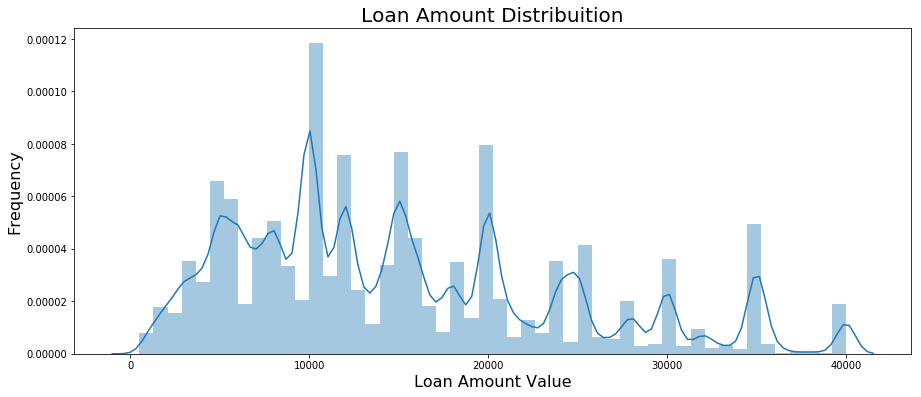

In [20]:
#Explore loan_amnt
plt.figure(figsize = (15,6))
g=sns.distplot(mydata.loan_amnt)
g.set_xlabel("Loan Amount Value", fontsize=16)
g.set_ylabel("Frequency", fontsize=16)
g.set_title("Loan Amount Distribuition", fontsize=20)


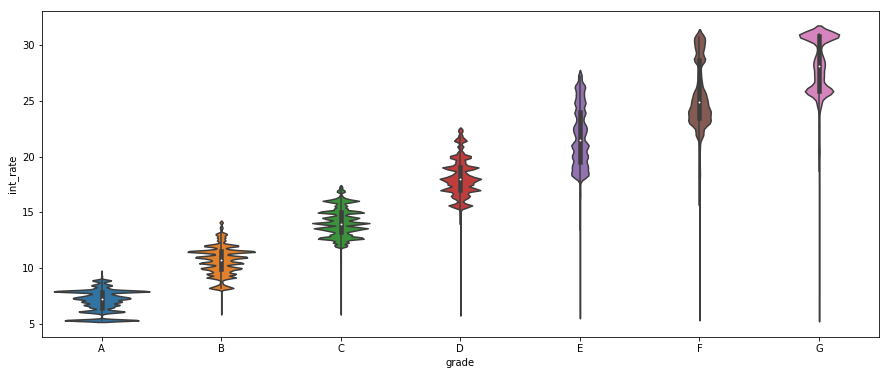

In [31]:
#Explore interest rate by grade
plt.subplots(figsize=(15,6))
sns.violinplot(x="grade", y="int_rate", data=mydata, order="ABCDEFG")

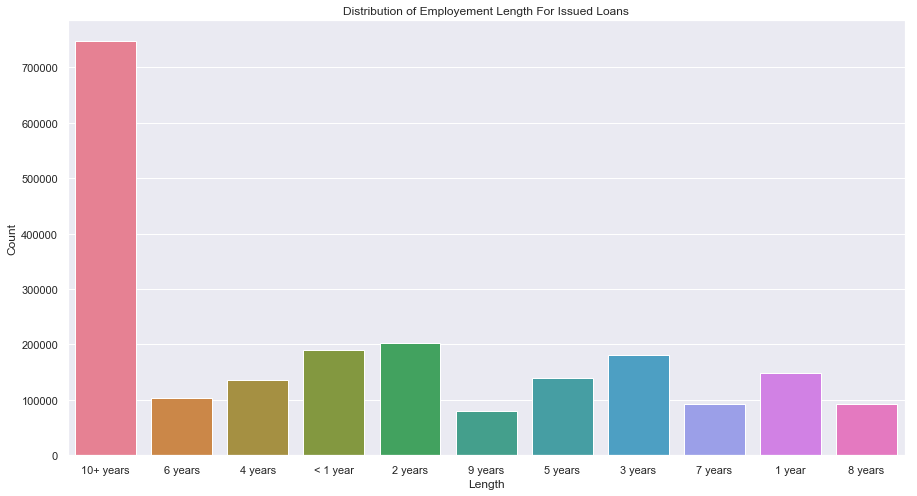

In [34]:
sns.set(rc={'figure.figsize':(15,8)})
sns.countplot(mydata['emp_length'],palette='husl')
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Employement Length For Issued Loans")
plt.show()

loan amount is little skewed to the right

In [7]:
mydata.loan_status.value_counts()

Fully Paid                                             1041952
Current                                                919695 
Charged Off                                            261655 
Late (31-120 days)                                     21897  
In Grace Period                                        8952   
Late (16-30 days)                                      3737   
Does not meet the credit policy. Status:Fully Paid     1988   
Does not meet the credit policy. Status:Charged Off    761    
Default                                                31     
Name: loan_status, dtype: int64

In [8]:
#remove 'Does note meet the credit policy'
delind=mydata[(mydata['loan_status']=='Does not meet the credit policy. Status:Fully Paid') | 
             (mydata['loan_status']=='Does not meet the credit policy. Status:Charged Off')].index
mydata=mydata.drop(delind)
print(mydata.loan_status.value_counts())
mydata.shape

Fully Paid            1041952
Current               919695 
Charged Off           261655 
Late (31-120 days)    21897  
In Grace Period       8952   
Late (16-30 days)     3737   
Default               31     
Name: loan_status, dtype: int64


(2257919, 46)

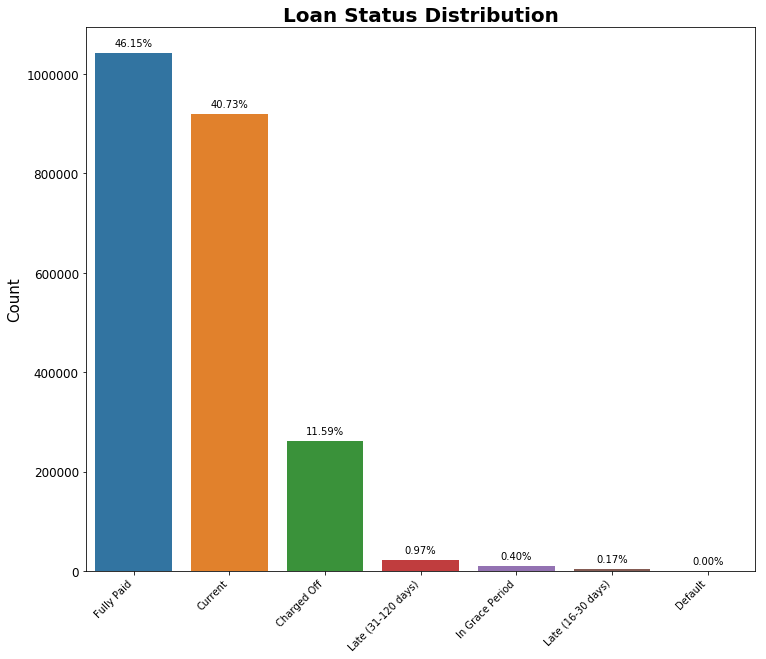

In [9]:
plt.figure(figsize = (12,10))
graph=sns.barplot(mydata.loan_status.value_counts().index, mydata.loan_status.value_counts())
plt.xticks(rotation = 45, horizontalalignment='right')
plt.yticks(fontsize = 12)
plt.title("Loan Status Distribution", fontsize = 20, weight='bold')
plt.ylabel("Count", fontsize = 15)
for p in graph.patches:
    graph.annotate('{:1.2f}%'.format(p.get_height()/len(mydata)*100), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [10]:
#Reclassify loan as good (1) or bad(0) loan
mydata.replace(['Fully Paid', 'Current', 'In Grace Period'],1,inplace=True)
mydata.replace(['Charged Off','Late (31-120 days)','Late (31-120 days) ', 'Late (16-30 days)', 'Default'],0,inplace=True)

In [24]:
#Explore the relation of features with loan status
purp_loan= ['purpose', 'loan_status']
cm = sns.light_palette("green", as_cmap=True)
(round(pd.crosstab(mydata[purp_loan[0]], mydata[purp_loan[1]], 
                   normalize='columns') * 100,2)).style.background_gradient(cmap = cm)

loan_status,0,1
purpose,,
car,0.8,1.1
credit_card,18.6,23.51
debt_consolidation,61.21,55.87
educational,0.02,0.01
home_improvement,5.84,6.77
house,0.61,0.63
major_purchase,2.08,2.25
medical,1.28,1.21
moving,0.82,0.66


In [25]:
#Explore loan_status with Grade
loan_grade = ['loan_status', 'grade']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(mydata[loan_grade[0]], mydata[loan_grade[1]]).style.background_gradient(cmap = cm)

grade,A,B,C,D,E,F,G
loan_status,,,,,,,
0,15349,56665,92238,65263,37929,15097,4779
1,417580,606538,557186,258470,97174,26456,7195


Text(0, 0.5, 'Loan Amount')

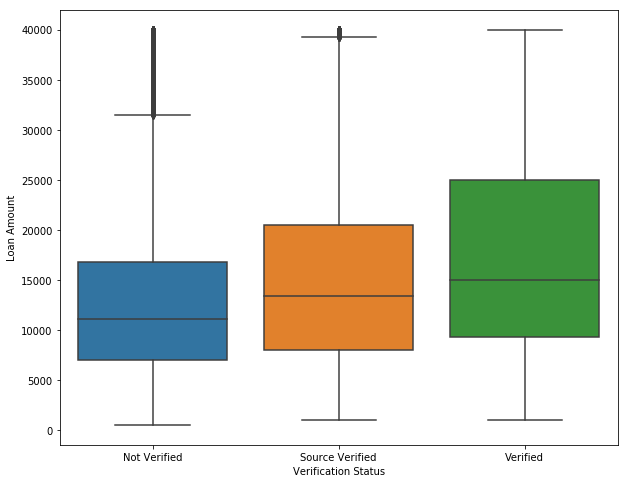

In [28]:
plt.figure(figsize=(10,8))
sns.boxplot(x=mydata.verification_status, y=mydata.loan_amnt)
plt.xlabel("Verification Status")
plt.ylabel("Loan Amount")

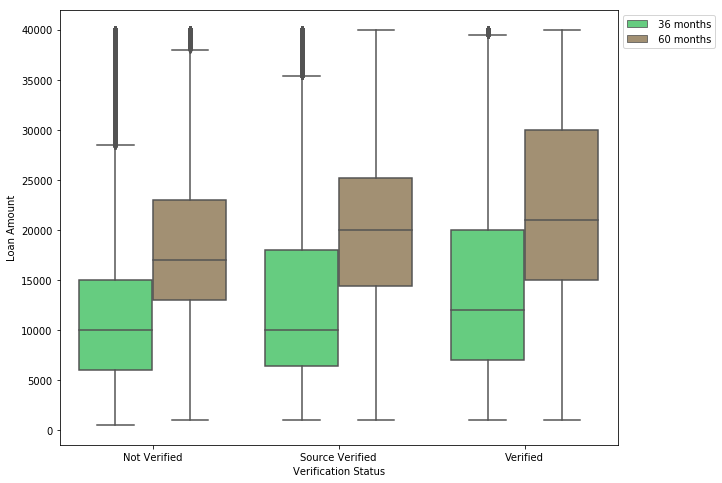

In [30]:
plt.figure(figsize=(10,8))
sns.boxplot(x=mydata.verification_status, y=mydata.loan_amnt, hue=mydata.term, palette="terrain")
plt.xlabel("Verification Status")
plt.ylabel("Loan Amount")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)

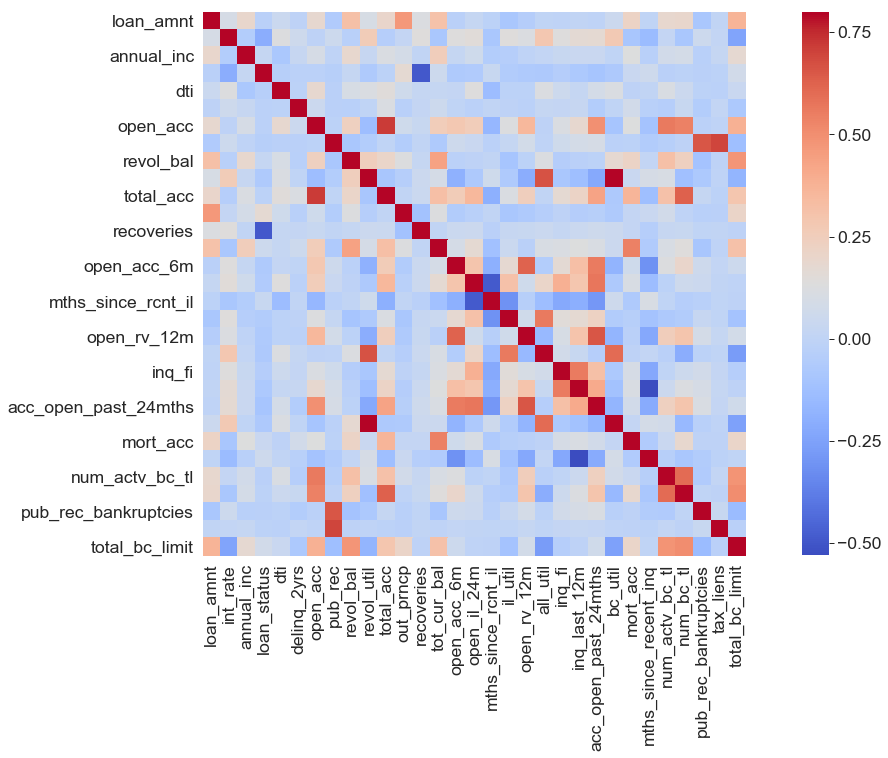

In [38]:
#Heatmap
plt.figure(figsize=(20,10))
sns.heatmap(mydata.corr(), vmax=.8, square=True,cmap='coolwarm')

In [11]:
#Check the correlation with loan_status and remove the features with very low correlation
abs(mydata.corr()['loan_status']).sort_values()[0:10]

tot_coll_amt                  0.000273
total_bal_il                  0.002427
delinq_amnt                   0.003703
chargeoff_within_12_mths      0.004957
total_cu_tl                   0.006466
acc_now_delinq                0.007982
collections_12_mths_ex_med    0.009902
num_bc_tl                     0.012561
tax_liens                     0.013531
total_acc                     0.014027
Name: loan_status, dtype: float64

In [62]:
#Remove the variables with low correlation (r<0.01)
mydata=mydata.drop(['tot_coll_amt','total_bal_il','delinq_amnt','chargeoff_within_12_mths',
                   'total_cu_tl','acc_now_delinq','collections_12_mths_ex_med'],axis=1)
mydata.shape

(2260668, 39)

In [41]:
#missing values
df_null = pd.DataFrame({'count': mydata.isnull().sum(), 'percent': round(100*mydata.isnull().sum()/len(mydata),2)})
df_null[df_null['count']!=0].sort_values(by=['count'],ascending=False)

,count,percent
il_util,1066101,47.22
mths_since_rcnt_il,907175,40.18
all_util,863599,38.25
inq_last_12m,863381,38.24
open_acc_6m,863381,38.24
inq_fi,863380,38.24
open_il_24m,863380,38.24
open_rv_12m,863380,38.24
mths_since_recent_inq,292686,12.96
emp_length,146873,6.50


In [63]:
#Replace missing values
mydata['mths_since_rcnt_il'].fillna(0,inplace=True)
mydata['il_util'].fillna(0,inplace=True)
mydata['open_rv_12m'].fillna(0,inplace=True)
mydata['open_il_24m'].fillna(0,inplace=True)
mydata['open_acc_6m'].fillna(0,inplace=True)
mydata['inq_last_12m'].fillna(0,inplace=True)
mydata['open_acc_6m'].fillna(0,inplace=True)
mydata['inq_fi'].fillna(0,inplace=True)
mydata['mths_since_recent_inq'].fillna(0,inplace=True)
mydata['num_bc_tl'].fillna(0,inplace=True)
mydata['num_actv_bc_tl'].fillna(0,inplace=True)
mydata['bc_util'].fillna(0,inplace=True)
mydata['num_actv_bc_tl'].fillna(0,inplace=True)
mydata['mths_since_rcnt_il'].fillna(0,inplace=True)
mydata['acc_open_past_24mths'].fillna(0,inplace=True)
mydata['pub_rec_bankruptcies'].fillna(0,inplace=True)
mydata['mort_acc'].fillna(0,inplace=True)
mydata['revol_util'].fillna(0,inplace=True)
mydata['tax_liens'].fillna(0,inplace=True)
mydata['pub_rec'].fillna(0,inplace=True)
mydata['all_util'].fillna(mydata['all_util'].mean(),inplace=True)
mydata['tot_cur_bal'].fillna(mydata['tot_cur_bal'].mean(),inplace=True)
mydata['total_bc_limit'].fillna(mydata['total_bc_limit'].mean(),inplace=True)
mydata['dti'].fillna(mydata['dti'].mean(),inplace=True)
mydata['annual_inc'].fillna(mydata['dti'].mean(),inplace=True)
mydata['open_acc'].fillna(mydata['open_acc'].median(),inplace=True)
mydata['total_acc'].fillna(mydata['total_acc'].median(),inplace=True)
mydata['delinq_2yrs'].fillna(mydata['delinq_2yrs'].median(),inplace=True)
mydata['emp_length'].fillna('10+ years',inplace=True)

In [43]:
#missing values
mydata.isna().sum().sort_values().head()

loan_amnt             0
open_acc_6m           0
open_il_24m           0
mths_since_rcnt_il    0
il_util               0
dtype: int64

In [44]:
#Finding categorial variables
mydata.dtypes[mydata.dtypes == "object"].index

Index(['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
       'purpose', 'application_type', 'disbursement_method'],
      dtype='object')

In [45]:
#convert to categorical variable
#Convert categorical variables as string
trans=('term', 'grade', 'emp_length','home_ownership','verification_status','purpose','application_type','disbursement_method') 
for name in trans:
    mydata[name]=mydata[name].astype(str)

mydata.emp_length[mydata.emp_length == '10+ years'] = '10 years' 
mydata.emp_length[mydata.emp_length == '< 1 year']   = '0 year'

#label encoding cat var
nom = ('term', 'grade', 'emp_length') 
       
for c in nom:
    lbl = LabelEncoder() 
    mydata[c] = lbl.fit_transform(list(mydata[c].values))

print(mydata.shape)

#,'home_ownership','verification_status','purpose','application_type','disbursement_method'

(2257919, 39)


In [46]:
#create dummy variables for nominal variables
df=pd.get_dummies(mydata)
print(df.shape)

(2257919, 61)


In [47]:
y=df.loan_status
X=df.drop(['loan_status'],axis=1)
print(X.shape)

(2257919, 60)


In [48]:
#splitting data into training and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4, random_state=24)
X_val, X_test, y_val, y_test=train_test_split(X_test, y_test, test_size=0.5, random_state=24)

In [49]:
#Check the proportion of data in each set
for d in (y_train, y_val, y_test):
    print(round(len(d)/len(y),2))

0.6
0.2
0.2


In [50]:
#Good bad ratio in y_train
y_train.value_counts()/len(y_train)

1    0.873135
0    0.126865
Name: loan_status, dtype: float64

In [51]:
#We have sufficient data, so we can take sub sample to make the good/bad ratio same
X = pd.concat([X_train, y_train], axis=1)
bad = X[X.loan_status==0]
good = X[X.loan_status==1]

good_down = resample(good,      replace = False, # sample without replacement
                                n_samples = len(bad), # match same length
                                random_state = 42)
Xdown = pd.concat([good_down, bad])
Xdown.loan_status.value_counts()

1    171870
0    171870
Name: loan_status, dtype: int64

In [52]:
#New X_train and y_train
y_train=Xdown.loan_status
X_train=Xdown.drop('loan_status',axis=1)

In [53]:
#Scaling the features. RobustScaler gives better results
from sklearn.preprocessing import StandardScaler, RobustScaler
sc=RobustScaler()
X_train2=sc.fit_transform(X_train)
X_val2=sc.transform(X_val)
X_test2=sc.transform(X_test)

In [54]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start = time()
    mdfit = model.fit(X_train, y_train)
    pred=model.predict(X_test)
    end = time()
    accuracy = round(accuracy_score(y_test, pred), 3)  #percentage of correct predictions
    precision = round(precision_score(y_test, pred), 3)
    recall = round(recall_score(y_test, pred), 3)
    f1score=round(f1_score(y_test, pred), 3)
    print('-- Accuracy: {} / Precision: {} / Recall: {} /f1score:{} / Latency: {}ms'.format(accuracy,precision,recall,
                                                                                    f1score,round((end - start)*1000, 1)))
def print_results(results):
    print('BEST PARAMS: {}\\n'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
          print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [62]:
#Logistic Regression
lr=LogisticRegression()
parameters={
    'C':[ 0.01, 0.1, 1, 10,100]
}
cv=GridSearchCV(lr, parameters, cv=5)
cv.fit(X_train2, y_train.values.ravel())
print_results(cv)

BEST PARAMS: {'C': 100}\n
0.809 (+/-0.002) for {'C': 0.01}
0.811 (+/-0.002) for {'C': 0.1}
0.813 (+/-0.002) for {'C': 1}
0.817 (+/-0.002) for {'C': 10}
0.818 (+/-0.002) for {'C': 100}


In [22]:
log_reg=LogisticRegression(C=100)
evaluate_model(log_reg,X_train2, y_train, X_val2, y_val)

-- Accuracy: 0.908 / Precision: 0.956 / Recall: 0.938 /f1score:0.947 / Latency: 144779.7ms


In [42]:
#DecisionTree Classifier
tree_clf=DecisionTreeClassifier()
parameters={
    'max_depth':[3,5,7],
    'min_samples_leaf':[3,5,7]

}

cv=GridSearchCV(tree_clf, parameters, cv=10)
cv.fit(X_train2, y_train.values.ravel())
print_results(cv)

BEST PARAMS: {'max_depth': 7, 'min_samples_leaf': 7}\n
0.806 (+/-0.003) for {'max_depth': 3, 'min_samples_leaf': 3}
0.806 (+/-0.003) for {'max_depth': 3, 'min_samples_leaf': 5}
0.806 (+/-0.003) for {'max_depth': 3, 'min_samples_leaf': 7}
0.822 (+/-0.004) for {'max_depth': 5, 'min_samples_leaf': 3}
0.822 (+/-0.004) for {'max_depth': 5, 'min_samples_leaf': 5}
0.822 (+/-0.004) for {'max_depth': 5, 'min_samples_leaf': 7}
0.829 (+/-0.003) for {'max_depth': 7, 'min_samples_leaf': 3}
0.829 (+/-0.003) for {'max_depth': 7, 'min_samples_leaf': 5}
0.829 (+/-0.003) for {'max_depth': 7, 'min_samples_leaf': 7}


In [57]:
#Decision Tree Classifier
tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3,min_samples_leaf=10)
evaluate_model(tree_clf,X_train2, y_train, X_val2, y_val)

-- Accuracy: 0.951 / Precision: 0.947 / Recall: 1.0 /f1score:0.973 / Latency: 1143.9ms


In [ ]:
#SVM
svc=SVC()
parameters={
    'kernel':['linear','rbf'],
    'C':[0.1,1,10]
}

cv=GridSearchCV(svc, parameters, cv=5)
cv.fit(X_train2, y_train.values.ravel())
print_results(cv)

In [ ]:
svc=SVC(kernel='linear',C=0.025)
evaluate_model(svc,X_train2, y_train, X_val2, y_val)

In [26]:
#Random Forest Classifier
rf=RandomForestClassifier()
parameters={
    'n_estimators':[5,50,250],
    'max_depth':[2,4,8,16,32]

}

cv=GridSearchCV(rf, parameters, cv=5)
cv.fit(X_train2, y_train.values.ravel())
print_results(cv)

BEST PARAMS: {'max_depth': 32, 'n_estimators': 250}\n
0.753 (+/-0.092) for {'max_depth': 2, 'n_estimators': 5}
0.796 (+/-0.025) for {'max_depth': 2, 'n_estimators': 50}
0.786 (+/-0.003) for {'max_depth': 2, 'n_estimators': 250}
0.803 (+/-0.018) for {'max_depth': 4, 'n_estimators': 5}
0.804 (+/-0.016) for {'max_depth': 4, 'n_estimators': 50}
0.807 (+/-0.011) for {'max_depth': 4, 'n_estimators': 250}
0.817 (+/-0.014) for {'max_depth': 8, 'n_estimators': 5}
0.829 (+/-0.005) for {'max_depth': 8, 'n_estimators': 50}
0.83 (+/-0.002) for {'max_depth': 8, 'n_estimators': 250}
0.822 (+/-0.004) for {'max_depth': 16, 'n_estimators': 5}
0.834 (+/-0.003) for {'max_depth': 16, 'n_estimators': 50}
0.835 (+/-0.002) for {'max_depth': 16, 'n_estimators': 250}
0.804 (+/-0.001) for {'max_depth': 32, 'n_estimators': 5}
0.832 (+/-0.003) for {'max_depth': 32, 'n_estimators': 50}
0.835 (+/-0.002) for {'max_depth': 32, 'n_estimators': 250}


In [63]:
#Random Forest Classifier
rf=RandomForestClassifier()
parameters={
    'n_estimators':[250,500],
    'max_depth':[16,32]

}

cv=GridSearchCV(rf, parameters, cv=10,verbose=10,n_jobs=-1)
cv.fit(X_train2, y_train.values.ravel())
print_results(cv)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 29.2min
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed: 29.6min remaining: 24.2min
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed: 39.3min remaining: 18.9min
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed: 48.0min remaining: 12.0min
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed: 48.3min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 50.4min finished


BEST PARAMS: {'max_depth': 32, 'n_estimators': 500}\n
0.835 (+/-0.003) for {'max_depth': 16, 'n_estimators': 250}
0.835 (+/-0.003) for {'max_depth': 16, 'n_estimators': 500}
0.835 (+/-0.004) for {'max_depth': 32, 'n_estimators': 250}
0.836 (+/-0.003) for {'max_depth': 32, 'n_estimators': 500}


In [55]:
#Random Forest Classifier
ran_clf=RandomForestClassifier(n_estimators=500,max_depth=16, n_jobs=-1)
evaluate_model(ran_clf,X_train2, y_train, X_val2, y_val)

-- Accuracy: 0.897 / Precision: 0.962 / Recall: 0.917 /f1score:0.939 / Latency: 129574.6ms


In [56]:
#Gradient Boosting Classifier
gb=GradientBoostingClassifier()
parameters={
    'n_estimators':[100,200],
    'max_depth':[3],
    'learning_rate':[0.01,1]

}

cv=GridSearchCV(gb, parameters, cv=10,verbose=10,n_jobs=-1)
cv.fit(X_train2, y_train.values.ravel())
print_results(cv)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done  22 out of  40 | elapsed: 43.3min remaining: 35.4min
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed: 61.5min remaining: 29.6min
[Parallel(n_jobs=-1)]: Done  32 out of  40 | elapsed: 75.8min remaining: 18.9min
[Parallel(n_jobs=-1)]: Done  37 out of  40 | elapsed: 78.6min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 80.2min finished


BEST PARAMS: {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 100}\n
0.817 (+/-0.004) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.82 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
0.834 (+/-0.004) for {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 100}
0.834 (+/-0.004) for {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 200}


In [62]:
#Gradient Boosting Classifier
gb=GradientBoostingClassifier(learning_rate= .01,n_estimators=100)
evaluate_model(gb,X_train2, y_train, X_val2, y_val)

-- Accuracy: 0.936 / Precision: 0.952 / Recall: 0.976 /f1score:0.964 / Latency: 56804.5ms


In [59]:
#Final Model
pred=tree_clf.predict(X_test)
accuracy = round(accuracy_score(y_test, pred), 3)  #percentage of correct predictions
precision = round(precision_score(y_test, pred), 3)
recall = round(recall_score(y_test, pred), 3)
f1score=round(f1_score(y_test, pred), 3)
print('-- Accuracy: {} / Precision: {} / Recall: {} /f1score:{}'.format(accuracy,precision,recall,
                                                                                    f1score))

-- Accuracy: 0.952 / Precision: 0.947 / Recall: 1.0 /f1score:0.973
